In [43]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


## **1. Load the data:**

In [44]:
import pandas as pd

df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Test Set Shape = {}'.format(df_test.shape))

Training Set Shape = (7613, 5)
Test Set Shape = (3263, 4)


## **2. Text Cleaning:**

#### *a) Remove URLs:*

In [45]:
import re

def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

#### *b) Remove special characters and numbers:*

In [46]:
def remove_special_characters(text):
    return re.sub(r'\W+|\d+', ' ', text)

#### *c) Convert to lowercase:*

In [47]:
def to_lowercase(text):
    return text.lower()

#### *d) Remove stopwords:*

In [48]:
import nltk
from nltk.corpus import stopwords

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### *e) Apply stemming or lemmatization:*

In [49]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def stem_text(text):
    return ' '.join([stemmer.stem(word) for word in text.split()])

In [50]:
from nltk.stem import WordNetLemmatizer

# Download wordnet
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### *Clean the dataset now:*

In [51]:
df_train['cleaned_text'] = df_train['text'].apply(remove_urls)
df_train['cleaned_text'] = df_train['cleaned_text'].apply(remove_special_characters)
df_train['cleaned_text'] = df_train['cleaned_text'].apply(to_lowercase)
df_train['cleaned_text'] = df_train['cleaned_text'].apply(remove_stopwords)
# Choose either stemming or lemmatization
df_train['cleaned_text'] = df_train['cleaned_text'].apply(stem_text)
# OR
# df['cleaned_text'] = df['cleaned_text'].apply(lemmatize_text)

df_test['cleaned_text'] = df_test['text'].apply(remove_urls)
df_test['cleaned_text'] = df_test['cleaned_text'].apply(remove_special_characters)
df_test['cleaned_text'] = df_test['cleaned_text'].apply(to_lowercase)
df_test['cleaned_text'] = df_test['cleaned_text'].apply(remove_stopwords)
# Choose either stemming or lemmatization
df_test['cleaned_text'] = df_test['cleaned_text'].apply(stem_text)
# OR
# df['cleaned_text'] = df['cleaned_text'].apply(lemmatize_text)

## **3. Exploratory Data Analysis (EDA):**

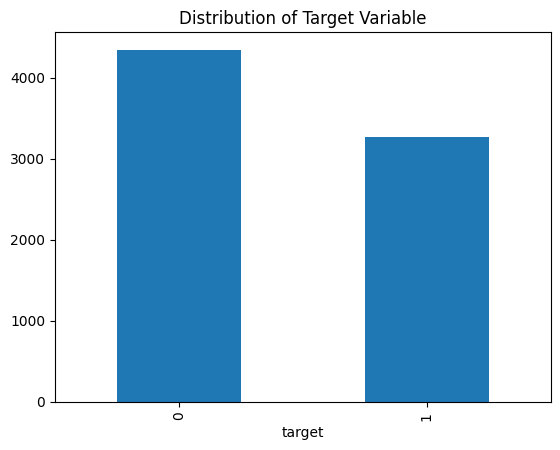

In [52]:
import matplotlib.pyplot as plt

df_train['target'].value_counts().plot(kind='bar')
plt.title('Distribution of Target Variable')
plt.show()

#### ***a) Word frequencies:***

In [53]:
from collections import Counter

# Tokenized words from the cleaned text
all_words = ' '.join(df_train['cleaned_text']).split()
word_freq = Counter(all_words)

# Most common words
common_words = word_freq.most_common(10)
print(common_words)

[('like', 411), ('fire', 363), ('û_', 344), ('amp', 344), ('get', 311), ('bomb', 239), ('new', 226), ('via', 220), ('news', 210), ('one', 206)]


In [54]:
disaster_words = ' '.join(df_train[df_train['target'] == 1]['cleaned_text']).split()
non_disaster_words = ' '.join(df_train[df_train['target'] == 0]['cleaned_text']).split()

disaster_freq = Counter(disaster_words)
non_disaster_freq = Counter(non_disaster_words)

# You can then visualize these using bar plots or word clouds, as described above.

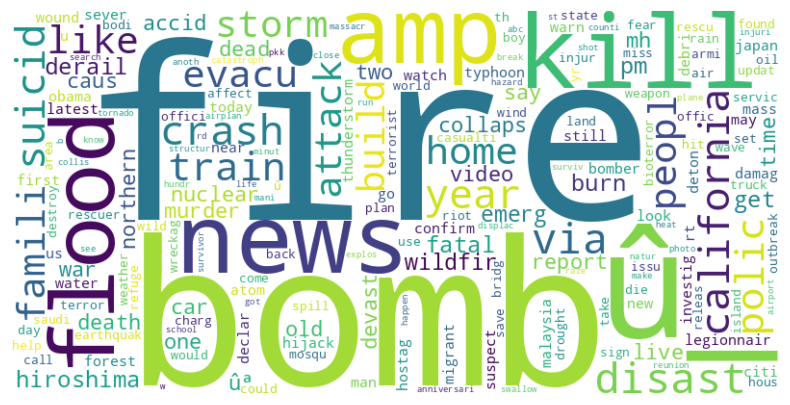

In [55]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(disaster_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

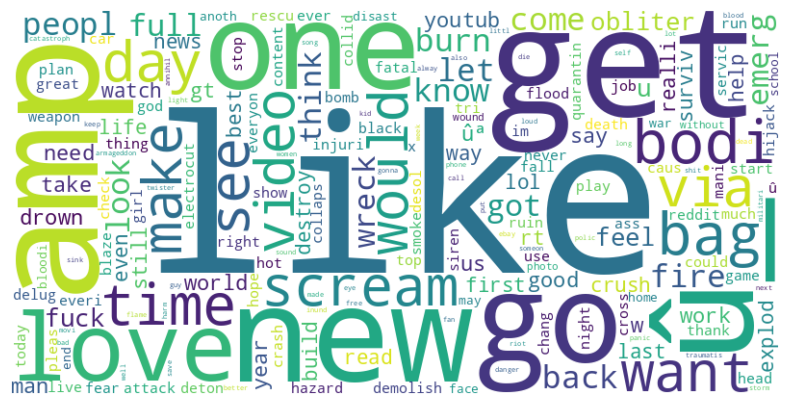

In [56]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(non_disaster_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### ***c) Missing Values:***

In [57]:
print(df_train.isnull().sum())
print(df_test.isnull().sum())

id                 0
keyword           61
location        2533
text               0
target             0
cleaned_text       0
dtype: int64
id                 0
keyword           26
location        1105
text               0
cleaned_text       0
dtype: int64


## **4. Model Building:**

#### ***a) Install required libraries:***

In [60]:
!pip install transformers
!pip install torch torchvision

#### ***b) Tokenization:***

In [61]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the training and testing data
train_encodings = tokenizer(list(df_train['cleaned_text']), truncation=True, padding=True, max_length=256)
test_encodings = tokenizer(list(df_test['cleaned_text']), truncation=True, padding=True, max_length=256)

#### ***c) Data Preparation:***

In [62]:
import torch

class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

train_dataset = TweetDataset(train_encodings, df_train['target'].tolist())
test_dataset = TweetDataset(test_encodings)

#### ***d) Model Initialization:***

In [63]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### ***e) Training:***

In [79]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',   # Output directory for model checkpoints and results
    per_device_train_batch_size=8,
    num_train_epochs=3,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)

trainer.train()

Step,Training Loss
500,0.448900
1000,0.445100
1500,0.404200
2000,0.386900
2500,0.365700


TrainOutput(global_step=2856, training_loss=0.40487328964789043, metrics={'train_runtime': 5035.4697, 'train_samples_per_second': 4.536, 'train_steps_per_second': 0.567, 'total_flos': 504678351396060.0, 'train_loss': 0.40487328964789043, 'epoch': 3.0})

## **5. Evaluation:**

In [80]:
predictions_train = trainer.predict(train_dataset)
predictions = trainer.predict(test_dataset)

print('Train: {}'.format(predictions_train))
print('Test: {}'.format(predictions))
# print('Train: {}'.format(metrics.accuracy_score(df_train["target"], predictions_train)))
# print('Test: {}'.format(metrics.accuracy_score(y_test, y_pred_class)))

Train: PredictionOutput(predictions=array([[-1.6588672,  1.7348913],
       [-1.8631585,  1.8629954],
       [-1.8483858,  1.8554106],
       ...,
       [-1.8607985,  1.8628573],
       [-1.8624994,  1.8628811],
       [-1.8644837,  1.862802 ]], dtype=float32), label_ids=array([1, 1, 1, ..., 1, 1, 1]), metrics={'test_loss': 0.33711981773376465, 'test_runtime': 427.7556, 'test_samples_per_second': 17.798, 'test_steps_per_second': 2.226})
Test: PredictionOutput(predictions=array([[-1.6628515,  1.7351525],
       [-1.3785268,  1.5202323],
       [-1.859937 ,  1.862532 ],
       ...,
       [-1.861319 ,  1.8626181],
       [-1.863396 ,  1.8629588],
       [-0.7813581,  1.1581563]], dtype=float32), label_ids=None, metrics={'test_runtime': 182.7984, 'test_samples_per_second': 17.85, 'test_steps_per_second': 2.232})


In [82]:
from sklearn.metrics import classification_report, accuracy_score

# Convert logits to class labels
y_true = df_train["target"].tolist()
y_pred = np.argmax(predictions_train.predictions, axis=1)

# Compute metrics
report = classification_report(y_true, y_pred, output_dict=True)  # Assuming y_val are the true labels for the validation set
accuracy = accuracy_score(y_true, y_pred)

print(f"F1-score:  {report['weighted avg']['f1-score']}")
print(f"Precision: {report['weighted avg']['precision']}")
print(f"Recall:    {report['weighted avg']['recall']}")
print(f"Accuracy:  {accuracy}")

F1-score:  0.8899767651521414
Precision: 0.8917437115511311
Recall:    0.8907132536450808
Accuracy:  0.8907132536450808


In [83]:
final_test_predictions = np.argmax(predictions.predictions, axis=1)

## **6. Submission:**

In [84]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [85]:
sample_submission['target'] = final_test_predictions
sample_submission.to_csv('submission.csv', index=False)
sample_submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1
